# Analiza comorbidităților

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Citirea datelor
df = pd.read_csv('anonim-clean.csv')

# Funcție pentru a extrage comorbidități dintr-un șir de caractere
def extract_comorbidities(s):
    if pd.isna(s):
        return []
    return [c.strip() for c in s.split(',')]

# Extragerea și numărarea comorbidităților
all_comorbidities = []
for app in df['app']:
    all_comorbidities.extend(extract_comorbidities(app))

# Numărarea frecvenței comorbidităților
comorbidity_counts = Counter(all_comorbidities)

# Sortarea comorbidităților după frecvență și selectarea primelor 10
top_10_comorbidities = dict(sorted(comorbidity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

# Crearea graficului
plt.figure(figsize=(12, 6))
plt.bar(top_10_comorbidities.keys(), top_10_comorbidities.values())
plt.title('Top 10 Comorbidități la Pacienții cu Spondilodiscită')
plt.xlabel('Comorbiditate')
plt.ylabel('Frecvență')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afișarea graficului
plt.show()

# Afișarea rezultatelor numerice
print("Top 10 Comorbidități:")
for comorbidity, count in top_10_comorbidities.items():
    print(f"{comorbidity}: {count}")

Top 10 Comorbidități:
hta: 26
dz_ii: 12
icc: 10
fia: 8
spondilodiscită: 8
obezitate: 8
anemie: 6
hdl: 5
brc: 3
irc: 3


# comorbidități și numărul de investigații medicale efectuate pe pacienți

<Figure size 1200x600 with 0 Axes>

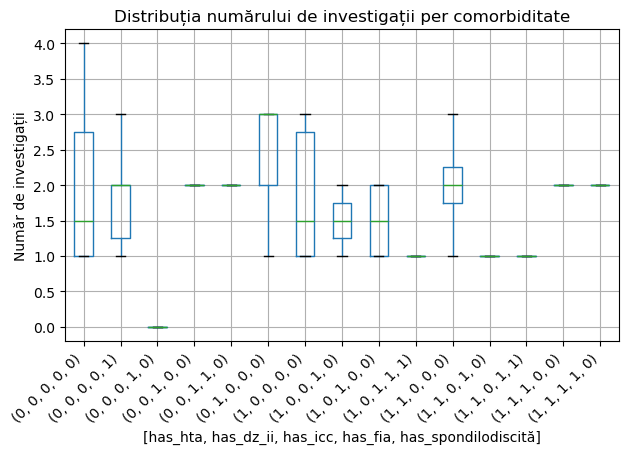

Media investigațiilor per comorbiditate:
hta: 1.69
dz_ii: 1.92
icc: 1.70
fia: 1.25
spondilodiscită: 1.62
Optimization terminated successfully.
         Current function value: 1.384089
         Iterations 5

Rezultatele regresiei Poisson:
                          Poisson Regression Results                          
Dep. Variable:     num_investigations   No. Observations:                   48
Model:                        Poisson   Df Residuals:                       42
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Oct 2024   Pseudo R-squ.:                 0.01596
Time:                        12:39:34   Log-Likelihood:                -66.436
converged:                       True   LL-Null:                       -67.514
Covariance Type:            nonrobust   LLR p-value:                    0.8272
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from statsmodels.formula.api import poisson
import statsmodels.api as sm

# Citirea datelor
df = pd.read_csv('anonim-clean.csv')

# Funcție pentru a extrage comorbidități și investigații
def extract_items(s):
    if pd.isna(s):
        return []
    return [c.strip() for c in s.split(',')]

# Extragerea comorbidităților și investigațiilor
df['comorbidities'] = df['app'].apply(extract_items)
df['investigations'] = df['metodă imagistică'].apply(extract_items)

# Numărarea investigațiilor pentru fiecare pacient
df['num_investigations'] = df['investigations'].apply(len)

# Selectarea celor mai comune 5 comorbidități
all_comorbidities = [item for sublist in df['comorbidities'] for item in sublist]
top_5_comorbidities = [x[0] for x in Counter(all_comorbidities).most_common(5)]

# Crearea variabilelor dummy pentru top 5 comorbidități
for comorbidity in top_5_comorbidities:
    df[f'has_{comorbidity}'] = df['comorbidities'].apply(lambda x: comorbidity in x).astype(int)

# Analiză descriptivă
plt.figure(figsize=(12, 6))
df.boxplot(column='num_investigations', by=[f'has_{c}' for c in top_5_comorbidities])
plt.title('Distribuția numărului de investigații per comorbiditate')
plt.suptitle('')
plt.ylabel('Număr de investigații')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calcularea și afișarea mediei investigațiilor pentru fiecare comorbiditate
print("Media investigațiilor per comorbiditate:")
for comorbidity in top_5_comorbidities:
    mean_investigations = df[df[f'has_{comorbidity}'] == 1]['num_investigations'].mean()
    print(f"{comorbidity}: {mean_investigations:.2f}")

# Pregătirea datelor pentru regresia Poisson
X = df[[f'has_{c}' for c in top_5_comorbidities]]
y = df['num_investigations']

# Adăugarea unei constante la predictori
X = sm.add_constant(X)

# Regresia Poisson
poisson_model = poisson('num_investigations ~ ' + ' + '.join([f'has_{c}' for c in top_5_comorbidities]), data=df).fit()

# Afișarea rezultatelor regresiei
print("\nRezultatele regresiei Poisson:")
print(poisson_model.summary())

# Interpretarea coeficienților
print("\nInterpretarea coeficienților (creșterea procentuală a numărului de investigații):")
for comorbidity in top_5_comorbidities:
    coef = poisson_model.params[f'has_{comorbidity}']
    increase = (np.exp(coef) - 1) * 100
    p_value = poisson_model.pvalues[f'has_{comorbidity}']
    print(f"{comorbidity}: {increase:.2f}% (p-value: {p_value:.4f})")